<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [ ]:
import os
import re
import math
import random
import collections

import nltk
import torch
import numpy
import wandb
import pandas
import pytorch_lightning

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed: int) -> None:
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random() -> None:
    return set_random_seed(RANDOM_STATE)
fix_random()

In [ ]:
wandb.login(anonymous = "allow")

## Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [ ]:
df_ria = pandas.read_csv('data/ria_news.tsv', sep = '\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [ ]:
df_vk = pandas.read_csv('data/vk_news.tsv', sep = '\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis = 1, inplace = True)
print(df_vk.shape)
df_vk.head()

В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [ ]:
df_comments = pandas.read_csv('data/vk_comments.tsv', sep = '\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

## А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.

## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

### 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [ ]:
# удалим все лишние пробелы и сделаем lowercase
df_ria['tags'] = (df_ria.tags.apply(lambda w: ','.join([item.strip() for item in w.lower().split(',')])))

tags = ','.join(list(df_ria.tags.values))
tags_cnt = collections.Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [ ]:
target_tags = { tag for tag, cnt in tags_cnt.most_common() if cnt > 30 }
len(target_tags)

Закодируем теги для OHE.

In [ ]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = { jtem: item for item, jtem in tag2idx.items() }

Почистим таргет от лишних тэгов.

In [ ]:
df_ria['target_tags'] = (df_ria.tags.apply(lambda w: [ tag2idx.get(item) for item in w.split(',') if item in target_tags ]))
df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

In [ ]:
df_ria.target_tags.values[:3]

### 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

stops_ru = set(nltk.corpus.stopwords.words('russian'))
len(stops_ru)

In [ ]:
def normalize_text(text):
    # сурово регулярками выкидываем мусорные символы
    is_null = not isinstance(text, str) and math.isnan(text)
    return "#UNK#" if is_null else re.sub('[^а-яa-z0-9 ]', '', text.lower()).strip()

def create_vocab(text, stops_ru = stops_ru):
    k = 2
    vocabulary = { "#PAD#": 0, "#UNK#": 1 }
    for word, _ in collections.Counter(nltk.tokenize.word_tokenize(text)).most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

In [ ]:
df_ria['title_clean'] = df_ria.title.apply(normalize_text)
print(len(create_vocab(' '.join(df_ria.title_clean.values))))
df_ria.head()

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [ ]:
df_vk['title_clean'] = df_vk.title.apply(normalize_text)
print(len(create_vocab(' '.join(df_vk.title_clean.values))))
df_vk.head()

In [ ]:
df_ria['snippet_clean'] = df_ria.snippet.apply(normalize_text)
print(len(create_vocab(' '.join(df_ria.snippet_clean.values))))
df_ria.head()

In [ ]:
df_vk['snippet_clean'] = df_vk.snippet.apply(normalize_text)
print(len(create_vocab(' '.join(df_vk.snippet_clean.values))))
df_vk.head()

### 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [ ]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))
df = df_ria[~df_ria.href.isin(test_hrefs)]

По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [ ]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [ ]:
df.date.min(), df.date.max()

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [ ]:
october_mask = df_ria.date.apply(lambda date: date.startswith('2018-10-'))
november_mask = df_ria.date.apply(lambda date: date.startswith('2018-11-'))
december_mask = df_ria.date.apply(lambda date: date.startswith('2018-12-'))

df_test = df_ria[december_mask]
df_val = df_ria[october_mask | november_mask]
df_train = df_ria[~(october_mask | november_mask | december_mask)]
assert len(df_test) + len(df_val) + len(df_train) == len(df_ria)
print('Val:', len(df_val), df_val.date.min(), df_val.date.max())
print('Test:', len(df_test), df_test.date.min(), df_test.date.max())
print('Train:', len(df_train), df_train.date.min(), df_train.date.max())

Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [ ]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean', 'snippet_clean']]
df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

Напишем датасет для поставки данных в нейросеть.


In [ ]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            num_classes, targets,
            vocab, vocab_size,
            titles, title_len,
            snippets = None, snippet_len = None
        ):
        self.y = self.target_ohe(num_classes, targets)
        self.vocab = { word: idx for word, idx in vocab.items() if idx < vocab_size }
        self.titles = self.create_text(titles, title_len)
        self.snippets = self.create_text(snippets, snippet_len)

    def target_ohe(self, num_classes, target):
        y = torch.zeros((len(target), num_classes))
        for i, t in enumerate(target):
            y[[ i ] * len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len = 100000000):
        if texts is None: return None
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [ self.vocab.get(item, 1) for item in nltk.tokenize.word_tokenize(sent) ]
            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len: sent_tokenize = sent_tokenize[:max_len]
            else: sent_tokenize += [ 0 ] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype = torch.int)

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        if self.snippets is None: return (self.titles[idx, :], self.y[idx])
        else: return (self.titles[idx, :], self.snippets[idx, :], self.y[idx])

__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [ ]:
NUM_CLASSES = len(idx2tag)
VOCAB_SIZE = 30000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
titles_vocabulary = create_vocab(' '.join(df_train.title_clean.values))

# объявляем датасеты
titles_train_ds = NewsDataset(
    NUM_CLASSES, df_train.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_train.title_clean.values, MAX_TITLE_LEN
)
titles_val_ds = NewsDataset(
    NUM_CLASSES, df_val.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_val.title_clean.values, MAX_TITLE_LEN
)
titles_test_ds = NewsDataset(
    NUM_CLASSES, df_test.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_test.title_clean.values, MAX_TITLE_LEN
)
titles_oob_ds = NewsDataset(
    NUM_CLASSES, df_oob.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_oob.title_clean.values, MAX_TITLE_LEN
)

# даталоадеры
titles_train_loader = torch.utils.data.DataLoader(titles_train_ds, shuffle = True, batch_size = 64)
titles_val_loader = torch.utils.data.DataLoader(titles_val_ds, shuffle = False, batch_size = 4096)

In [ ]:
MAX_SNIPPET_LEN = 50

# словарь создаем по всей выборке
snippets_vocabulary = create_vocab(' '.join(df_train.title_clean.values))

# объявляем датасеты
snippets_train_ds = NewsDataset(
    NUM_CLASSES, df_train.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_train.title_clean.values, MAX_TITLE_LEN,
    df_train.snippet_clean.values, MAX_SNIPPET_LEN
)
snippets_val_ds = NewsDataset(
    NUM_CLASSES, df_val.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_val.title_clean.values, MAX_TITLE_LEN,
    df_val.snippet_clean.values, MAX_SNIPPET_LEN
)
snippets_test_ds = NewsDataset(
    NUM_CLASSES, df_test.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_test.title_clean.values, MAX_TITLE_LEN,
    df_test.snippet_clean.values, MAX_SNIPPET_LEN
)
snippets_oob_ds = NewsDataset(
    NUM_CLASSES, df_oob.target_tags.values,
    titles_vocabulary, VOCAB_SIZE,
    df_oob.title_clean.values, MAX_TITLE_LEN,
    df_oob.snippet_clean.values, MAX_SNIPPET_LEN
)

# даталоадеры
snippets_train_loader = torch.utils.data.DataLoader(snippets_train_ds, shuffle = True, batch_size = 64)
snippets_val_loader = torch.utils.data.DataLoader(snippets_val_ds, shuffle = False, batch_size = 4096)

### 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [ ]:
class TitlesClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.fc = torch.nn.Linear(embedding_dim, output_dim)

    def forward(self, titles):
        return self.fc(self.embedding(titles).mean(dim = 1))

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [ ]:
class TrainLightningModule(pytorch_lightning.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, titles):
        return self.model(titles)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.learning_rate)

    def training_step(self, train_batch, batch_idx):
        logits = self.model(*train_batch[:-1])
        loss = self.criterion(logits, train_batch[-1])
        self.log("train_loss", loss, prog_bar = True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        logits = self.model(*val_batch[:-1])
        loss = self.criterion(logits, val_batch[-1])
        self.log("val_loss", loss, prog_bar = True)
        return loss

Обучим модель.

In [ ]:
LR = 1e-3
EPOCHS = 5
EMBEDDING_DIM = 300

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
titles_model = TitlesClassifier(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES)
trainer = pytorch_lightning.Trainer(accelerator = "gpu", max_epochs = EPOCHS)

train_module = TrainLightningModule(titles_model, LR, criterion)
trainer.fit(train_module, titles_train_loader, titles_val_loader)

__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [ ]:
wandb_logger = pytorch_lightning.loggers.WandbLogger(project = "DL-HW-4", name = "titles", log_model = "all")
trainer = pytorch_lightning.Trainer(accelerator = "gpu", max_epochs = EPOCHS, logger = wandb_logger)
titles_model = TitlesClassifier(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES)

train_module = TrainLightningModule(titles_model, LR, criterion)
trainer.fit(train_module, titles_train_loader, titles_val_loader)
wandb.finish()

![Alternative Text][1702567258605]

[1702567258605]: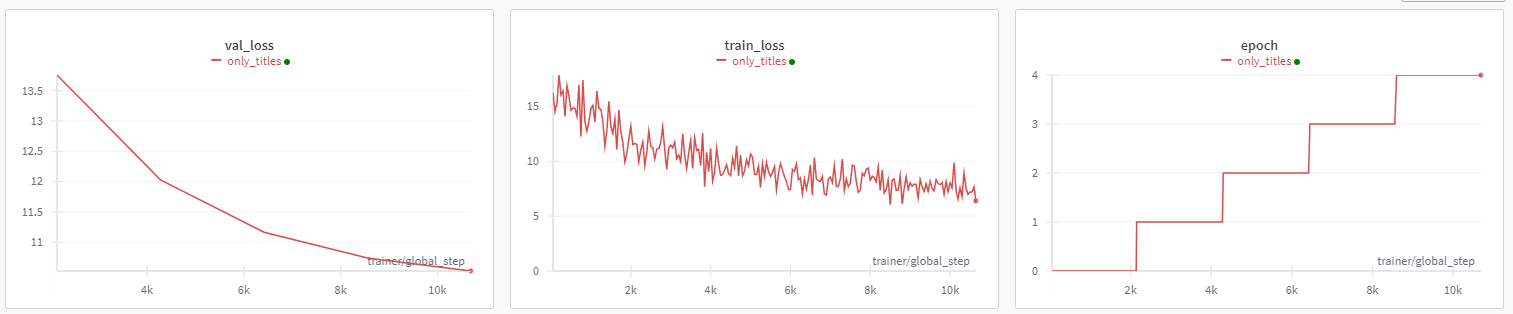

In [ ]:
class SnippetsClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.fc = torch.nn.Linear(2 * embedding_dim, output_dim)

    def forward(self, titles, snippets):
        embedded_titles = self.embedding(titles).mean(dim = 1)
        embedded_snippets = self.embedding(snippets).mean(dim = 1)
        return self.fc(torch.cat([ embedded_titles, embedded_snippets ], dim = 1))

In [ ]:
wandb_logger = pytorch_lightning.loggers.WandbLogger(project = "DL-HW-4", name = "snippets", log_model = "all")
trainer = pytorch_lightning.Trainer(accelerator = "gpu", max_epochs = EPOCHS, logger = wandb_logger)
snippets_model = SnippetsClassifier(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES)

train_module = TrainLightningModule(snippets_model, LR, criterion)
trainer.fit(train_module, snippets_train_loader, snippets_val_loader)
wandb.finish()

### 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim = 1)
    denum = (y_pred == 1).sum(dim = 1)
    return (num / (denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim = 1)
    denum = (target == 1).sum(dim = 1)
    return (num / (denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1. * (y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
test_loader = torch.utils.data.DataLoader(titles_test_ds, shuffle = False, batch_size = len(titles_test_ds))
for titles, target in test_loader:
    logit = titles_model(titles)
    pred_prob = torch.nn.functional.softmax(logit, dim = 1)

assert pred_prob.shape[0] == len(titles_test_ds)

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1 * (pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

In [ ]:
TRESHOLD = 0.05
y_pred = 1 * (pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

In [ ]:
TRESHOLD = 0.9
y_pred = 1 * (pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [ ]:
def get_predict(model, dataset):
    loader = torch.utils.data.DataLoader(dataset, shuffle = False, batch_size = len(dataset))
    for data in loader:
        logit = model(*data[:-1])
        pred_prob = torch.nn.functional.softmax(logit, dim = 1)
        assert pred_prob.shape[0] == len(dataset)
        return pred_prob, data[-1]

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ \
Ответ, безусловно, зависит от бизнес-задачи, которую мы пытаемся решить нашей моделью. С учётом только той информации, которая дана в задании, я считаю, что precision для нас важнее: лучше, чтобы у новости было мало тегов, все из которых действительно подходят, чем много тегов, большинство из которых не имеют отношения к реальному содержанию. \
Более того, для любых предсказаний можно выбрать порог (например, равный 0), при котором recall равен единице. В такой постановке любая модель работает идеально. Очевидно, это не то, что мы хотим: precision нужно учитывать в любом случае. При необходимости выбора только одной из метрик, целесообразно отдать предпочтение precision.

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [ ]:
def get_threshold(pred_prob, target, step = 0.002):
    target = target.to(device)
    pred_prob = pred_prob.to(device)
    best_precision = target.new_tensor([ 0. ])
    best_threshold = target.new_tensor([ 0. ])
    for threshold in torch.arange(0, 1, step):
        y_pred = 1 * (pred_prob > threshold)
        prec = precision(target, y_pred)
        if prec > best_precision:
            best_precision = prec
            best_threshold = threshold
    return best_threshold.item(), best_precision, recall(target, 1 * (pred_prob > best_threshold))

In [ ]:
get_threshold(*get_predict(titles_model, titles_val_ds))

In [ ]:
get_threshold(*get_predict(snippets_model, snippets_val_ds))

Интересно, модель без снипетов оказалась немного лучше.

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

In [ ]:
get_threshold(*get_predict(titles_model, titles_oob_ds))

In [ ]:
get_threshold(*get_predict(snippets_model, snippets_oob_ds))

Проседает, причем достаточно заметно.

### [NOT DONE] 1.6 Бонусное задание 

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.  

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# (⊙_⊙)

__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# =^･ｪ･^=

__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

-
-
-

In [ ]:
# your code here
# ٩(ˊ〇ˋ*)و


Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
# your code here
# (⌐■_■)

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]

# your code here
# (っ˘ڡ˘ς)

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [ ]:
# Ваш код с сохранением данных

# your code here
# ¯\_(ツ)_/¯

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [ ]:
df_comments.head()

Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
2. Как выглядит архитектура модели? Насколько модель большая?
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?

Установим библиотеку. 🤗🤗🤗

In [ ]:
!pip3 install transformers

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
# your code here
# ʕ•ᴥ•ʔ

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [ ]:
df_vk['sentiment_verdict'] = ...
df_vk['sentiment_score'] = ...

# <ваш код для сохранения данных>

# your code here
# ¯\_(ツ)_/¯

# P.S. Код для скоринга комментариев работает довольно долго. Первый, кто проскорит всю базу, может поделиться ей в общем чате с однокурсниками
# Если вы используете эту базу, просто продемонстрируйте при решении этого пункта, что ваш код работает

## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [ ]:
# your code here
# ʕ•ᴥ•ʔ

__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [ ]:
# your code here
# [✖‿✖]

__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [ ]:
# your code here
# ┌(ಠ_ಠ)┘

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [ ]:
# your code here
# ฅ^•ﻌ•^ฅ

Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

In [ ]:
# your code here
# ٩(⁎❛ᴗ❛⁎)۶

__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [ ]:
# your code here
# ヾ(๑╹◡╹)ﾉ